In [60]:
import numpy as np
from matplotlib import pyplot as plt

In [61]:
a = 5
b = 3
c = 0
l = np.pi
N = 100
K = 1000

alpha0 = 1
alphal = 1
betta0 = -1
bettal = -1

phi0 = lambda t: - np.exp(-a * t) * (np.cos(b * t) + np.sin(b * t))
phil = lambda t: np.exp(- a * t) * (np.cos(b * t) + np.sin(b * t))
gamma0 = lambda x: np.cos(x)
fResult = lambda x, t: np.exp(- a * t) * np.cos(x + b * t)

h = l /(N-1)
sigma = 0.4
taw = sigma / K
mu = b * taw / 2 / h
U = []

In [62]:
def plotSlice(f, X, t,q):
    plt.subplots(figsize = (20,10))
    plt.subplot(2, 2, q)
    plt.plot(X, f(X, t), label = 'точное')
    plt.xlabel('Момент времени: %.5f' %(t))
    plt.grid

In [79]:
def showPostProcess():
    t=0
    X = np.linspace(0, l, N)
    st=K//3
    print(st)
    for q in range(1,4):
        t=st*q
        plotSlice(fResult, X, taw * t, q)
        plt.subplot(2, 2, q)
        plt.plot(X, U[t], label = 'численное')
        plt.legend()

In [73]:
def Error(U, fR, count):
    X = np.linspace(0, l, N)
    Y = list(map(int, np.linspace(0, U.shape[0] - 1, count)))
    plt.subplot(2, 2, 4)
    plt.plot(Y, list(map(lambda tt: np.max(np.abs(U[tt] - fR(X, taw*tt))), Y)), label = 'error')
    plt.xlabel('График ошибки')
    plt.legend()

In [74]:
def gridFun(xCond, tCond):
    xlCond,xrCond = xCond
    tlCond, trCond = tCond
    return np.zeros((xrCond, trCond))

In [75]:
def explicitMethod(iCondition, bCondition, method="1"):

    def explicitWithFirstDegree():
        for k in range(0, K - 1):
            U[k + 1][0] = (- alpha0 / h * U[k + 1][1] + phi0(taw * (k + 1))) / (betta0 - alpha0 / h)
            U[k + 1][N - 1] = (alphal / h * U[k + 1][N - 2] + phil(taw * (k + 1))) / (bettal + alphal / h)
        pass

    def explicitWithSecondDegree():
        for k in range(0, K - 1):
            U[k + 1][0] = (- alpha0 / h / 2 * (4 * U[k + 1][1] - U[k + 1][2]) + phi0(taw * (k + 1))) / (
            betta0 - 3 * alpha0 / h / 2)
            U[k + 1][N - 1] = (- alphal / h / 2 * (U[k + 1][N - 3] - 4 * U[k + 1][N - 2]) + phil(taw * (k + 1))) / (
            bettal + 3 * alphal / h / 2)

    def explicitWithThirdDegree():
        b0 = 2*a/h + h/taw - h*c - betta0/alpha0*(2*a - b*h)
        c0 = -2*a/h
        bN = 2*a/h + h/taw - h*c + bettal/alphal*(2*a + b*h)
        aN = -2*a/h
        for k in range(0, K - 1):
            d0 = h/taw * U[k][0] - phi0(taw*(k + 1)) * (2*a - b*h) / alpha0
            dN = h/taw * U[k][N - 1] + phil(taw*(k + 1)) * (2*a + b*h) / alphal
            U[k + 1][0] = (d0 - c0 * U[k + 1][1]) / b0
            U[k + 1][N - 1] = (dN - aN * U[k + 1][N - 2]) / bN

    gamma0 = iCondition
    phi0, phil = bCondition
    U = gridFun((0, K), (0, N))
    for j in range(0, N):
        U[0][j] = gamma0(j * h)
    for k in range(0, K - 1):
        for j in range(1, N - 1):
            U[k + 1][j] = (sigma + mu) * U[k][j + 1] + (1 - 2 * sigma + taw * c) * U[k][j] + (sigma - mu) * U[k][
                j - 1]
            pass
    if method == 1:
        explicitWithFirstDegree()
    elif method == 2:
        explicitWithSecondDegree()
    elif method == 3:
        explicitWithThirdDegree()
    else:
        pass
    return U

In [76]:
def implicitMethod(iCondition, bCondition, method="1"):
    def implicitWithFirstDegree():
        b0 = betta0 - alpha0 / h
        c0 = alpha0 / h
        aN = - alphal / h
        bN = bettal + alphal / h

        def gA():
            aa = np.zeros((N, N))
            aa[0][0] = b0
            aa[0][1] = c0
            for j in range(1, N - 1):
                aa[j][j - 1] = aj
                aa[j][j] = bj
                aa[j][j + 1] = cj
            aa[N - 1][N - 2] = aN
            aa[N - 1][N - 1] = bN
            return aa

        def gB(k):
            bb = np.zeros((N, 1))
            bb[0][0] = phi0(taw * (k + 1))
            bb[N - 1][0] = phil(taw * (k + 1))
            for j in range(1, N - 1):
                bb[j][0] = - U[k][j]
            return bb
        return gA, gB

    def implicitWithSecondDegree():
        a0 = betta0 - 3*alpha0/ h/ 2
        b0 = 2 * alpha0/h
        c0 = - alpha0 / h /2
        aN = alphal / h /2
        bN = -2 * alphal/h
        cN = bettal + 3*alphal/ h/ 2

        def gA():
            aa = np.zeros((N, N))
            aa[0][0] = a0
            aa[0][1] = b0
            aa[0][2] = c0
            for j in range(1, N - 1):
                aa[j][j - 1] = aj
                aa[j][j] = bj
                aa[j][j + 1] = cj
            aa[N - 1][N - 2] = bN
            aa[N - 1][N - 1] = cN
            aa[N - 1][N - 3] = aN
            return aa

        def gB(k):
            bb = np.zeros((N, 1))
            bb[0][0] = phi0(taw * (k + 1))
            bb[N - 1][0] = phil(taw * (k + 1))
            for j in range(1, N - 1):
                bb[j][0] = - U[k][j]
            return bb
        return gA, gB

    def implicitWithThirdDegree():
        b0 = 2 * a / h + h / taw - h * c - betta0 / alpha0 * (2 * a - b * h)
        c0 = -2 * a / h
        bN = 2 * a / h + h / taw - h * c + bettal / alphal * (2 * a + b * h)
        aN = -2 * a / h
        def gA():
            aa = np.zeros((N, N))
            aa[0][0] = b0
            aa[0][1] = c0
            for j in range(1, N - 1):
                aa[j][j - 1] = aj
                aa[j][j] = bj
                aa[j][j + 1] = cj
            aa[N - 1][N - 2] = aN
            aa[N - 1][N - 1] = bN
            return aa

        def gB(k):
            bb = np.zeros((N, 1))
            d0 = h / taw * U[k][0] - phi0(taw * (k + 1)) * (2 * a - b * h) / alpha0
            dN = h / taw * U[k][N - 1] + phil(taw * (k + 1)) * (2 * a + b * h) / alphal
            bb[0][0] = d0
            bb[N - 1][0] = dN
            for j in range(1, N - 1):
                bb[j][0] = - U[k][j]
            return bb

        return gA, gB
    
    U = gridFun((0, K), (0, N))
    for j in range(0, N):
        U[0][j] = gamma0(j * h)
    aj = a * taw / h ** 2 - taw * b / 2 / h
    bj = taw * (c - 2 * a / h ** 2) - 1
    cj = a * taw / h ** 2 + taw * b / 2 / h
    if method == 1:
        getA, getB = implicitWithFirstDegree()
    elif method == 2:
        getA, getB = implicitWithSecondDegree()
    elif method == 3:
        getA, getB = implicitWithThirdDegree()
    else:
        return U
    A = getA()
    for k in range(0, K - 1):
        B = getB(k)
        U[k + 1] = np.linalg.solve(A, B)[:, 0]

    return U

In [77]:
def CrankNicolsonMethod(iCondition, bCondition, sgm):
    U = gridFun((0, K), (0, N))
    for j in range(0, N):
        U[0][j] = gamma0(j * h)

    aj = sgm * a * taw / h ** 2 - taw * b / 2 / h
    bj = taw * (c - sgm * 2 * a / h ** 2) - 1
    cj = sgm * a * taw / h ** 2 + taw * b / 2 / h

    a0 = betta0 - 3 * alpha0 / h / 2
    b0 = 2 * alpha0 / h
    c0 = - alpha0 / h / 2
    aN = alphal / h / 2
    bN = -2 * alphal / h
    cN = bettal + 3 * alphal / h / 2
    def getA():
        a = np.zeros((N, N))
        a[0][0] = a0
        a[0][1] = b0
        a[0][2] = c0
        for j in range(1, N - 1):
            a[j][j - 1] = aj
            a[j][j] = bj
            a[j][j + 1] = cj
        a[N - 1][N - 3] = aN
        a[N - 1][N - 2] = bN
        a[N - 1][N - 1] = cN
        return a

    def getB(k):
        b = np.zeros((N, 1))
        b[0][0] = phi0(taw * (k + 1))
        b[N - 1][0] = phil(taw * (k + 1))
        for j in range(1, N - 1):
            b[j][0] = - U[k][j] - (1 - sgm)*(a * taw /h ** 2) * (U[k][j + 1] - 2*U[k][j] + U[k][j - 1])
        return b

    A = getA()
    for k in range(0, K - 1):
        B = getB(k)
        U[k + 1] = np.linalg.solve(A, B)[:, 0]
    return U

333


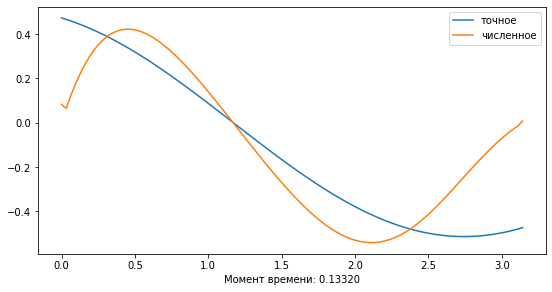

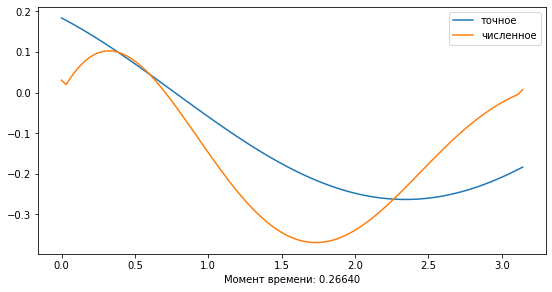

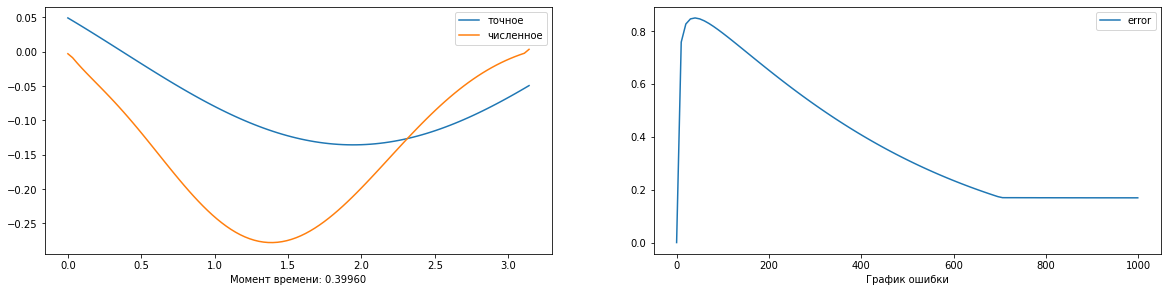

In [80]:
U = explicitMethod(gamma0,(phi0,phil),1)
showPostProcess()
Error(U, fResult, 100)
plt.show()

333


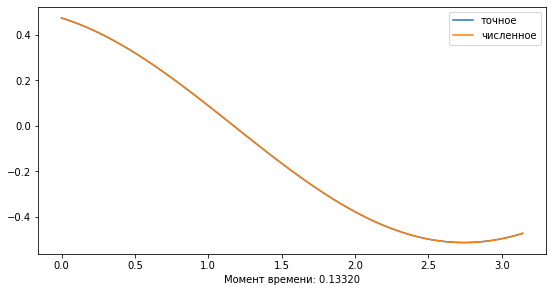

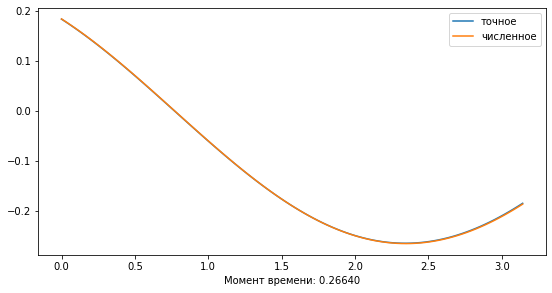

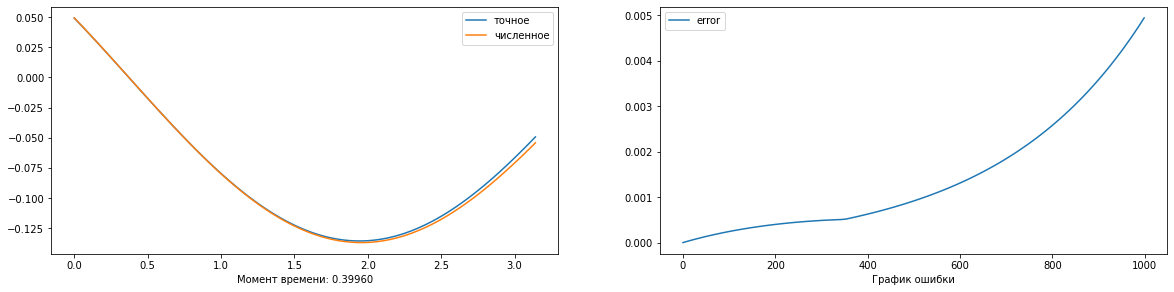

In [86]:
U = implicitMethod(gamma0, (phi0, phil), 2)
showPostProcess()
df = pd.DataFrame(U)
df.to_csv("output.csv", index=False)
Error(U, fResult, 100)
plt.show()

333


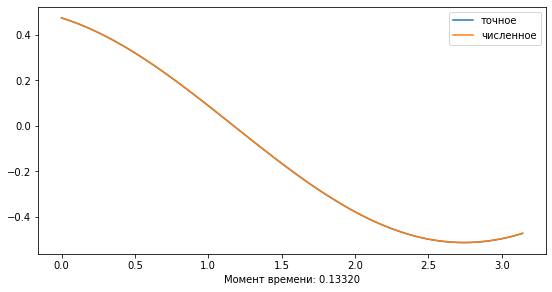

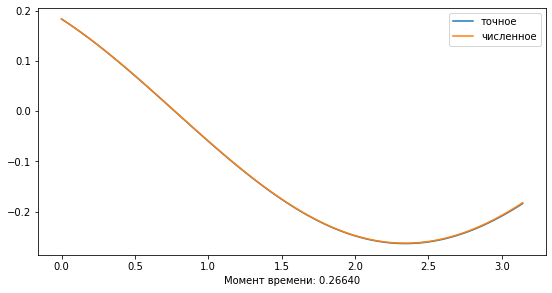

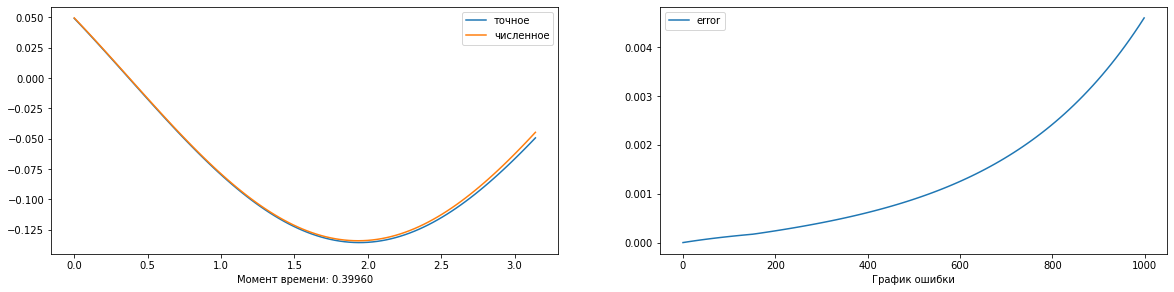

In [82]:
U = CrankNicolsonMethod(gamma0, (phi0, phil), 0.5)
showPostProcess()
Error(U, fResult, 100)
plt.show()